Dataset directory exists.
80134624/80134624 [==============================] - 0s 0us/step
Found 2193 images belonging to 4 classes.
Found 546 images belonging to 4 classes.
Epoch 1/10
69/69 [==============================] - 842s 12s/step - loss: 1.1368 - accuracy: 0.5062 - val_loss: 0.9448 - val_accuracy: 0.5623 - lr: 0.0010
Epoch 2/10
69/69 [==============================] - 143s 2s/step - loss: 0.8245 - accuracy: 0.6667 - val_loss: 0.7464 - val_accuracy: 0.7106 - lr: 0.0010
Epoch 3/10
69/69 [==============================] - 140s 2s/step - loss: 0.6577 - accuracy: 0.7560 - val_loss: 0.6195 - val_accuracy: 0.7454 - lr: 0.0010
Epoch 4/10
69/69 [==============================] - 139s 2s/step - loss: 0.5835 - accuracy: 0.7715 - val_loss: 0.6138 - val_accuracy: 0.7473 - lr: 0.0010
Epoch 5/10
69/69 [==============================] - 137s 2s/step - loss: 0.5180 - accuracy: 0.8067 - val_loss: 0.5311 - val_accuracy: 0.8077 - lr: 0.0010
Epoch 6/10
69/69 [==============================] - 136

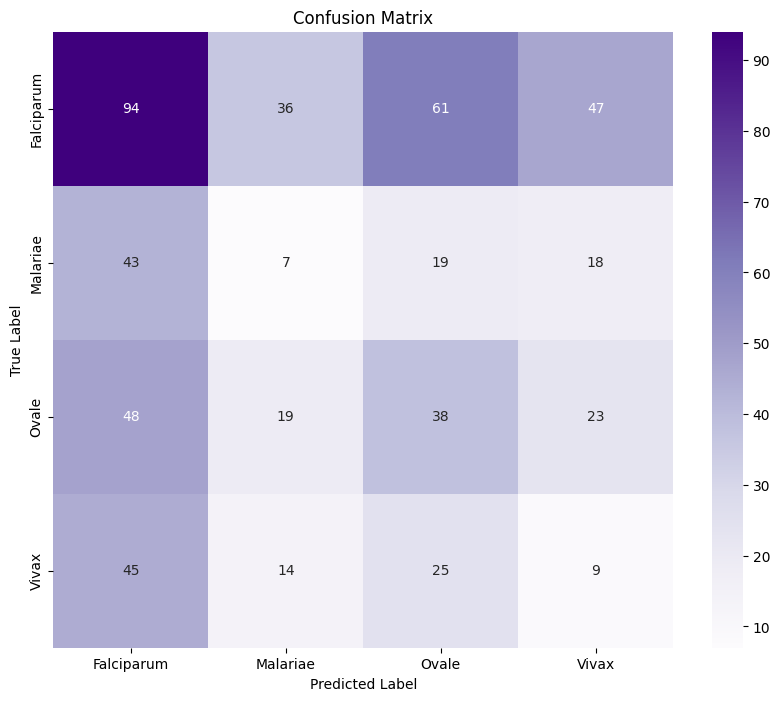

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

dataset_dir = '/content/drive/MyDrive/Malaria/infected'

if not os.path.exists(dataset_dir):
    print("Dataset directory does not exist.")
else:
    print("Dataset directory exists.")

num_stage_classes = len(os.listdir(dataset_dir))

base_model_stage = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x_stage = base_model_stage.output
x_stage = GlobalAveragePooling2D()(x_stage)
x_stage = Dense(128, activation='relu')(x_stage)
predictions_stage = Dense(num_stage_classes, activation='softmax')(x_stage)


model_stage = Model(inputs=base_model_stage.input, outputs=predictions_stage)

for layer in base_model_stage.layers:
    layer.trainable = False

model_stage.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen_stage = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    validation_split=0.2
)

train_generator_stage = train_datagen_stage.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator_stage = train_datagen_stage.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


early_stopping_stage = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint_stage = ModelCheckpoint('best_model_vgg19_stage.keras', save_best_only=True, monitor='val_loss')
reduce_lr_stage = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


history_stage = model_stage.fit(
    train_generator_stage,
    validation_data=validation_generator_stage,
    epochs=10,
    callbacks=[early_stopping_stage, model_checkpoint_stage, reduce_lr_stage]
)


loss_stage, accuracy_stage = model_stage.evaluate(validation_generator_stage)
print(f"Stage Validation Loss: {loss_stage}, Stage Validation Accuracy: {accuracy_stage}")

true_labels = validation_generator_stage.classes
class_indices = validation_generator_stage.class_indices
predictions = model_stage.predict(validation_generator_stage)
predicted_classes = np.argmax(predictions, axis=1)

cm = confusion_matrix(true_labels, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=list(class_indices.keys()),
            yticklabels=list(class_indices.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 0s 94ms/step


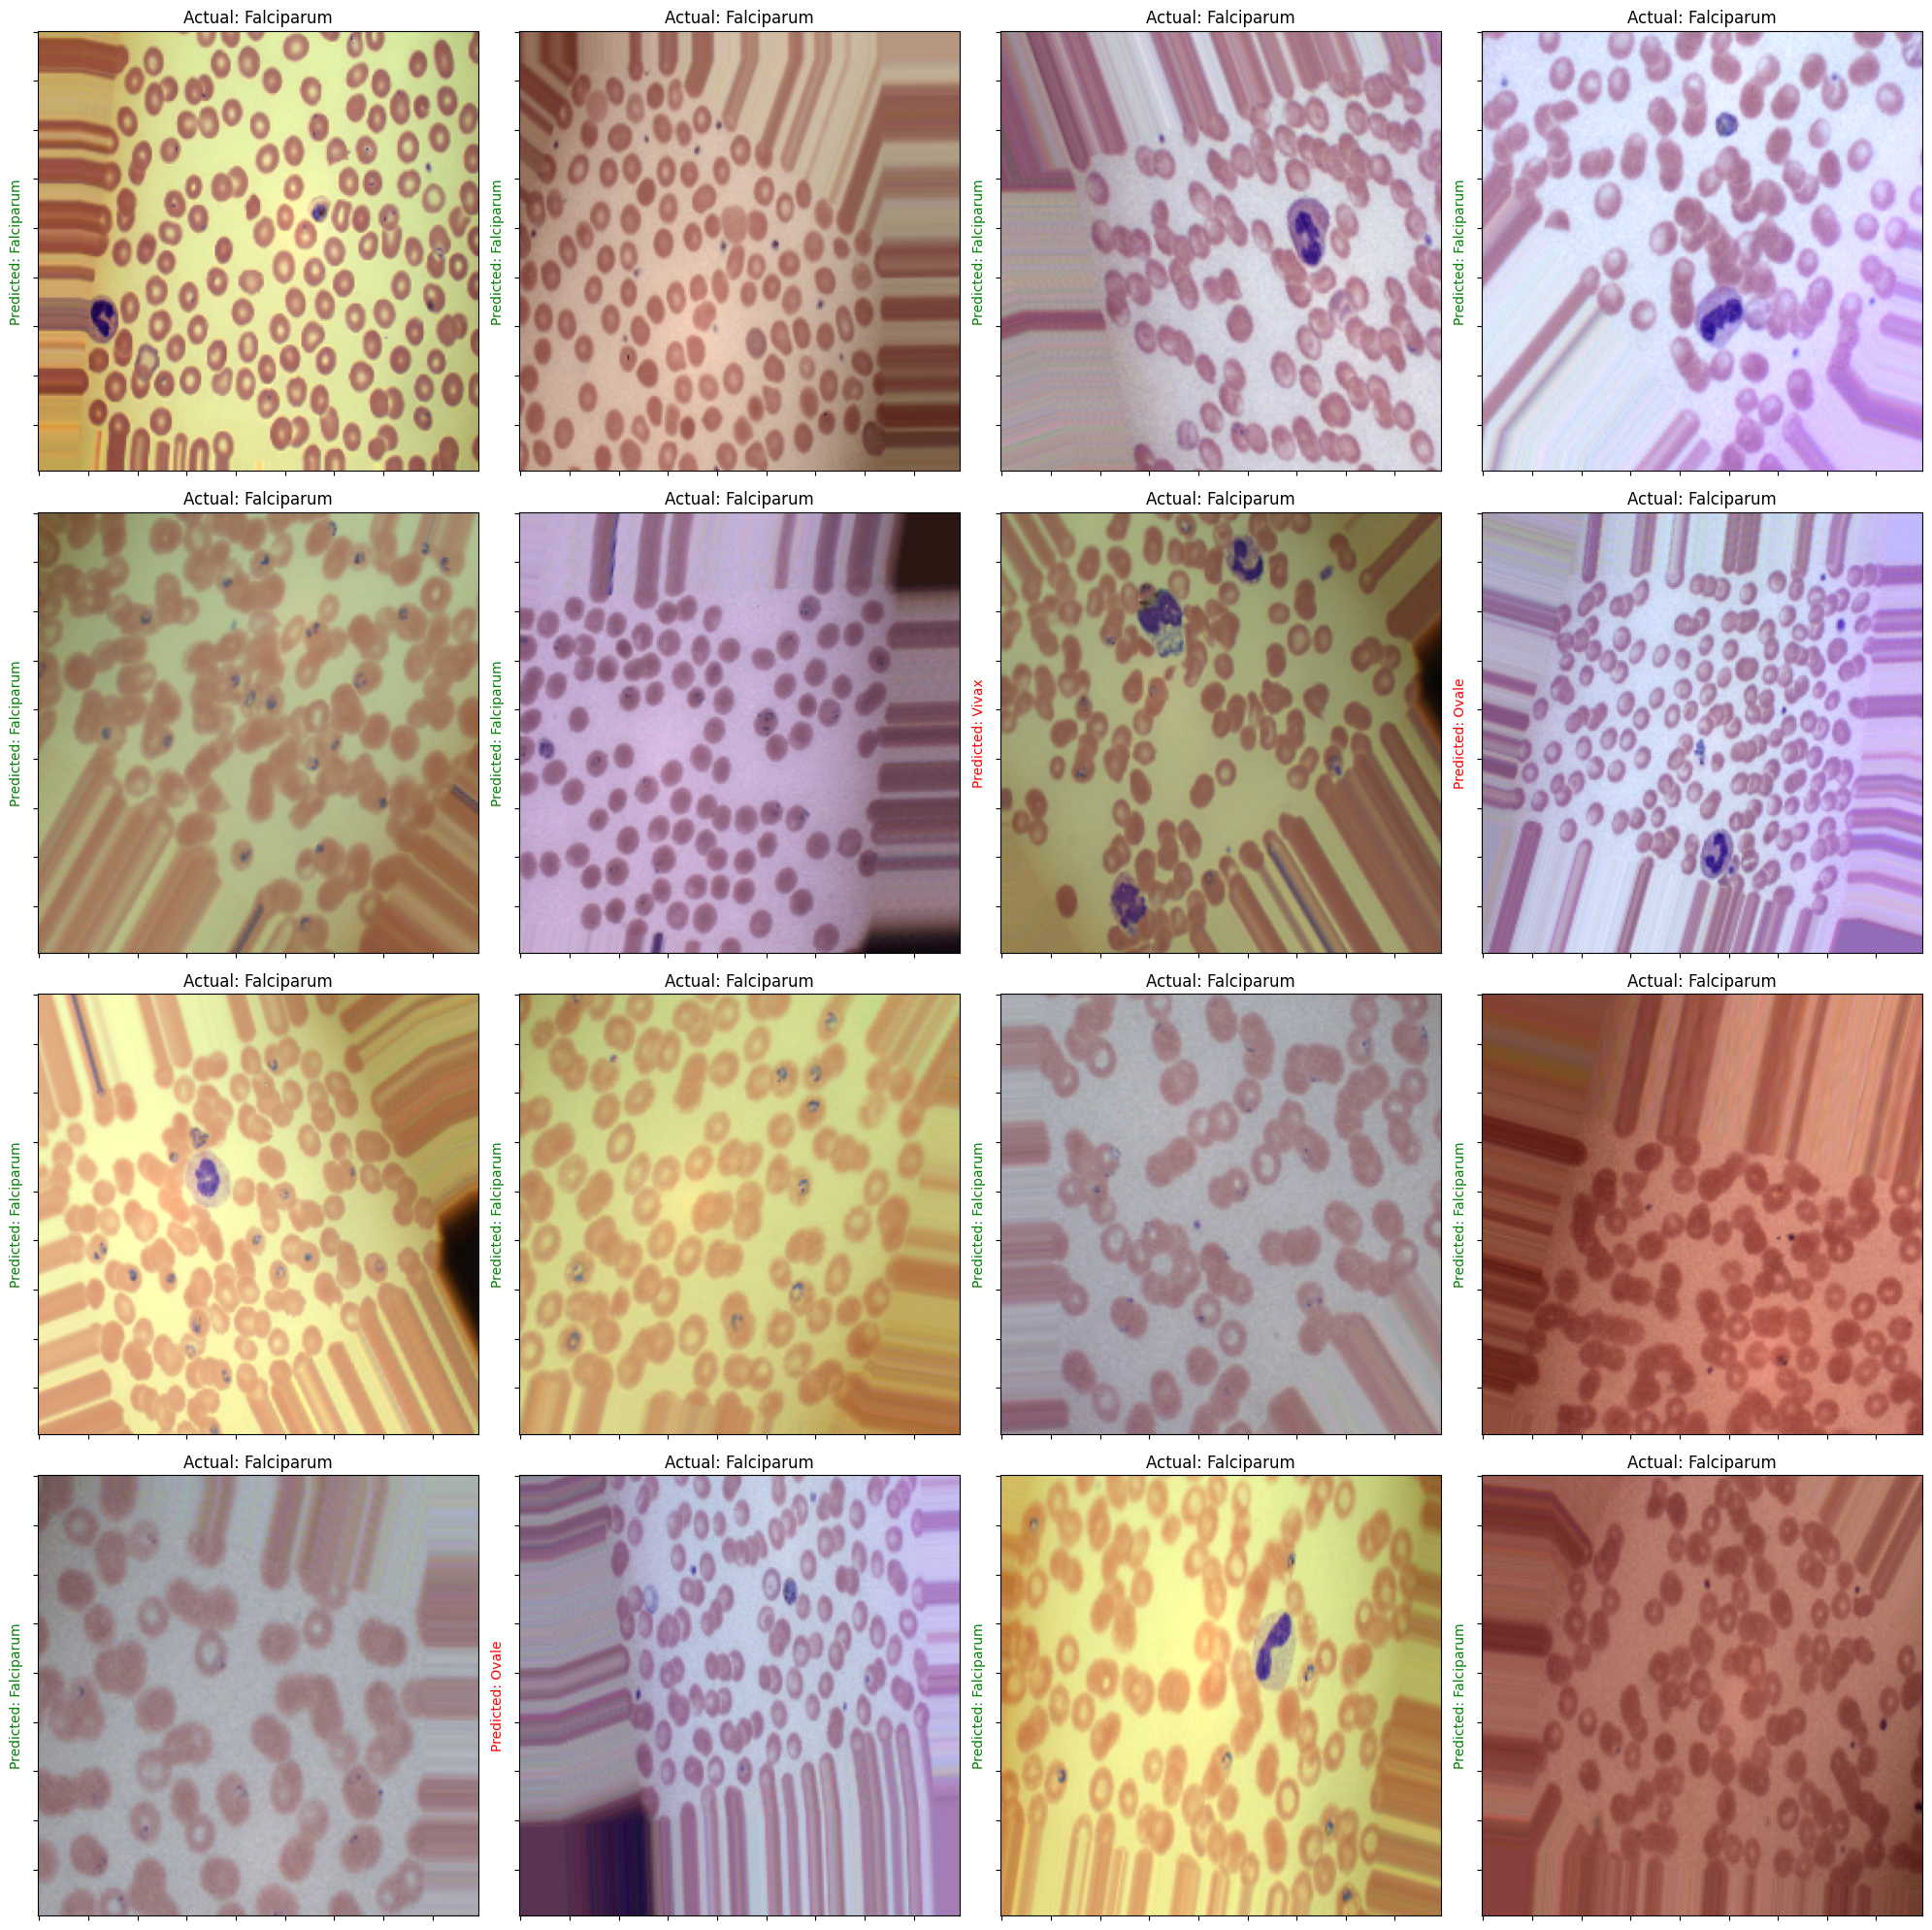

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 20))
class_names_main = train_generator_stage.class_indices
class_names_main = {v: k for k, v in class_names_main.items()}

# Take one batch of validation data for main classification
images_main, labels_main = next(validation_generator_stage)

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images_main[i])  # No need to convert to uint8 as they are already scaled
    predictions_main = model_stage.predict(tf.expand_dims(images_main[i], axis=0))

    score_main = tf.nn.softmax(predictions_main[0])
    predicted_class_main = class_names_main[np.argmax(score_main)]
    actual_class_main = class_names_main[np.argmax(labels_main[i])]

    plt.title(f"Actual: {actual_class_main}")

    if actual_class_main == predicted_class_main:
        plt.ylabel(f"Predicted: {predicted_class_main}", fontdict={'color': 'green'})
    else:
        plt.ylabel(f"Predicted: {predicted_class_main}", fontdict={'color': 'red'})

    plt.gca().axes.yaxis.set_ticklabels([])
    plt.gca().axes.xaxis.set_ticklabels([])

plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd
hist=pd.DataFrame(history_stage.history)
hist

loss  accuracy  val_loss  val_accuracy     lr
0  1.042526  0.553124  0.902179      0.639194  0.001
1  0.756483  0.698130  0.705772      0.714286  0.001
2  0.630372  0.763338  0.645846      0.736264  0.001
3  0.535525  0.803466  0.537847      0.796703  0.001
4  0.501906  0.806658  0.523289      0.807692  0.001
5  0.473044  0.827177  0.483577      0.815018  0.001
6  0.439492  0.830369  0.554765      0.769231  0.001
7  0.418682  0.839033  0.413349      0.840659  0.001
8  0.377360  0.858641  0.426817      0.838828  0.001
9  0.375125  0.859097  0.398285      0.853480  0.001

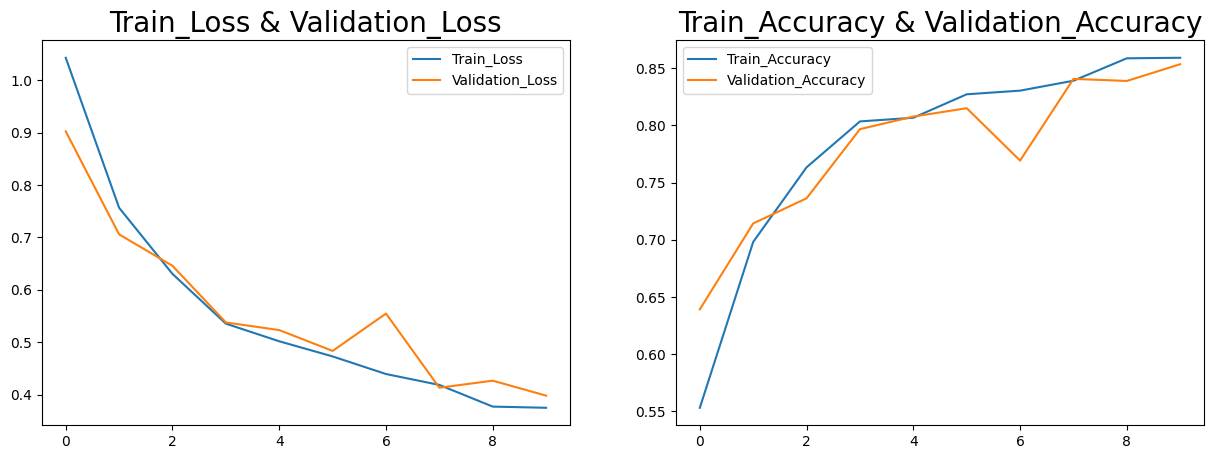

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist['loss'],label='Train_Loss')
plt.plot(hist['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist['accuracy'],label='Train_Accuracy')
plt.plot(hist['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [ ]:
model_stage.save('model_stage.keras')